## SEB Challenge
* [Input](#Input)
* [Data preparation](#Data-preparation)
* [Data exploration](#Data-exploration)
* [Feature creation and selection](#Feature-creation-and-selection)
* [Prediction](#Prediction)
* [Evaluation](#Evaluation)

# Input

In [1]:
#for manipulating data
import pandas as pd
from sklearn import preprocessing

#for plots
import seaborn as sns
import matplotlib.pyplot as plt

#for learning
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from xgboost.sklearn import XGBClassifier

#for evaluating
from sklearn.metrics import average_precision_score, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from xgboost import plot_importance, to_graphviz, plot_tree

#general
import numpy as np

In [2]:
file_path = '/home/anastasia/dataScience/SEB/'

customer_df = pd.read_csv(file_path+'Customer.csv')
district_df = pd.read_csv(file_path+'District.csv')
transaction_df = pd.read_csv(file_path+'Transaction.csv')

In [3]:
#checking the structure and if there are any nulls
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CLIENT_ID    4500 non-null   int64 
 1   ACCOUNT_ID   4500 non-null   int64 
 2   GENDER       4500 non-null   object
 3   BIRTH_DT     4500 non-null   int64 
 4   ACTIVE       4500 non-null   int64 
 5   LOAN         4500 non-null   int64 
 6   DISTRICT_ID  4500 non-null   int64 
 7   SET_SPLIT    4500 non-null   object
dtypes: int64(6), object(2)
memory usage: 281.4+ KB


In [4]:
#checking the structure and if there are any nulls
district_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DISTRICT_ID  77 non-null     int64  
 1   N_INHAB      77 non-null     int64  
 2   N_CITIES     77 non-null     int64  
 3   URBAN_RATIO  77 non-null     float64
 4   AVG_SALARY   77 non-null     int64  
 5   UNEMP_95     77 non-null     object 
 6   UNEMP_96     77 non-null     float64
 7   N_ENTR       77 non-null     int64  
 8   CRIME_95     77 non-null     object 
 9   CRIME_96     77 non-null     int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 6.1+ KB


In [5]:
#checking the structure and if there are any nulls
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   TRANS_ID    1056320 non-null  int64  
 1   ACCOUNT_ID  1056320 non-null  int64  
 2   DATE        1056320 non-null  int64  
 3   AMOUNT      1056320 non-null  float64
 4   BALANCE     1056320 non-null  float64
 5   TYPE        1056320 non-null  object 
 6   OPERATION   873206 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 56.4+ MB


In [6]:
transaction_df = transaction_df.fillna(value='Unknown').reset_index()
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   index       1056320 non-null  int64  
 1   TRANS_ID    1056320 non-null  int64  
 2   ACCOUNT_ID  1056320 non-null  int64  
 3   DATE        1056320 non-null  int64  
 4   AMOUNT      1056320 non-null  float64
 5   BALANCE     1056320 non-null  float64
 6   TYPE        1056320 non-null  object 
 7   OPERATION   1056320 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 64.5+ MB


Conclusions:
1. we will have to join customers with transactions to analyze customer's behaviour, and possible customers with district to get more info about their profile
2. the only column with nulls is OPERATION in the Transaction Dataframe; we will replace it by 'Unknown', indicating that the type of operation is unknown.

In [7]:
#check if a client can have multiple accounts

accounts_per_customer = customer_df.groupby('CLIENT_ID').ACCOUNT_ID.count()
print("Each customer has at least %d accounts" % accounts_per_customer.min())
print("Each customer has at most %d accounts" % accounts_per_customer.max())

Each customer has at least 1 accounts
Each customer has at most 1 accounts


There seems to be a 1-to-1 correspondence between clients and account IDs, allowing us to use either of them.

# Data preparation

In [8]:
#convert dates to datetime format for convenience
customer_df['BIRTH_DT'] = pd.to_datetime(customer_df['BIRTH_DT'], format='%Y%m%d')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format='%Y%m%d')



In [9]:
#if all customers are active, the column ACTIVE is not informative, so we drop it
if (customer_df.ACTIVE.sum() - len(customer_df) == 0):
    customer_df = customer_df.drop('ACTIVE', axis=1)

In [10]:
#splitting into train and test; we will not use the test split until model evaluation
customer_df_train = customer_df.loc[customer_df.SET_SPLIT == 'TRAIN'].drop('SET_SPLIT', axis=1)
customer_df_test = customer_df.loc[customer_df.SET_SPLIT == 'TEST'].drop('SET_SPLIT', axis=1)


In [11]:
#join the dataframes to see the transactions of each customer; we will use it for prediction, so doing the same for test split
cust_trans_train = pd.merge(left=customer_df_train, right=transaction_df, how='left', left_on='ACCOUNT_ID', right_on='ACCOUNT_ID')
cust_trans_test = pd.merge(left=customer_df_test, right=transaction_df, how='left', left_on='ACCOUNT_ID', right_on='ACCOUNT_ID')


# Data Exploration

TOTAL MONTHLY STATISTICS

Here we consider total monthly spendings: we group all transactions by date, and consider each month. For each month, we compute the min, max and average amount spent by all clients, as well as the number of transactions made by all clients together. We visualize the evolution of these values over time.

<ipython-input-12-ae4d777ccce7>:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  spent_over_time.columns = ["_".join(x) for x in spent_over_time.columns.ravel()]


<AxesSubplot:xlabel='time period', ylabel='amount spent over month'>

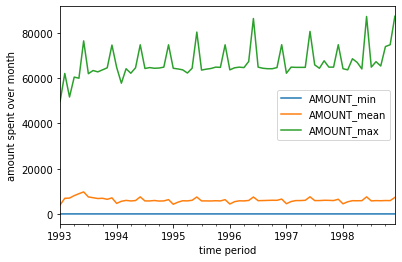

In [12]:
#group transactions over periods of time, choose 1 month as a period length
spent_over_time = transaction_df.groupby([pd.Grouper(key = 'DATE', freq='1M')]).agg({'AMOUNT' : ['min', 'mean', 'max']})#.reset_index()
spent_over_time.columns = ["_".join(x) for x in spent_over_time.columns.ravel()]
spent_over_time.plot(ylabel = 'amount spent over month', xlabel = 'time period')



<AxesSubplot:xlabel='time period', ylabel='transaction number'>

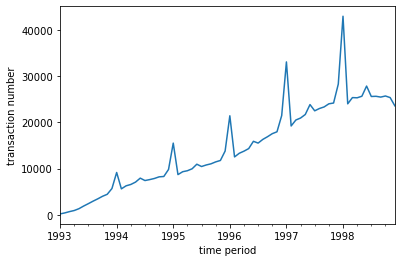

In [13]:
#total number of transactions over a time period (all customers)
transaction_df.groupby([pd.Grouper(key = 'DATE', freq='1M')]).TRANS_ID.count().plot(ylabel = 'transaction number', xlabel = 'time period')


Conclusion: we notice that the number of transactions per month significantly increased over time, while the amounts of money spent per transaction did not change that much over the years. 

Furthermore, we notice an interesting pattern: there are two spending peaks, one right before the end of the year, and one in the middle of the year. This probably corresponds to vacation seasons, when people tend to spend more.

STATISTICS FOR AN AVERAGE CLIENT

We now look at how the spendings of an average client look like. For this, we consider the joined dataframe of clients and their respective transactions, and group the transactions first over monthly periods and then over client IDs. We compute the total amount of money spent over an average month and the average number of transactions made over a month, and visualize how these amounts change over time.

In [14]:
def avg_client_per_month (cust_trans):
    trans_grouped_over_time = cust_trans.groupby([pd.Grouper(key = 'DATE', freq='1M'), 'CLIENT_ID'])
    avg_customer_stat = trans_grouped_over_time.agg({'AMOUNT': ['sum'], 'TRANS_ID': 'count'}).groupby('DATE').mean()
    avg_customer_stat.columns = ["_".join(x) for x in avg_customer_stat.columns.ravel()]
    avg_customer_stat = avg_customer_stat.reset_index()
    return avg_customer_stat

<ipython-input-14-214a3ef8c558>:4: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  avg_customer_stat.columns = ["_".join(x) for x in avg_customer_stat.columns.ravel()]


Text(0, 0.5, 'Time period')

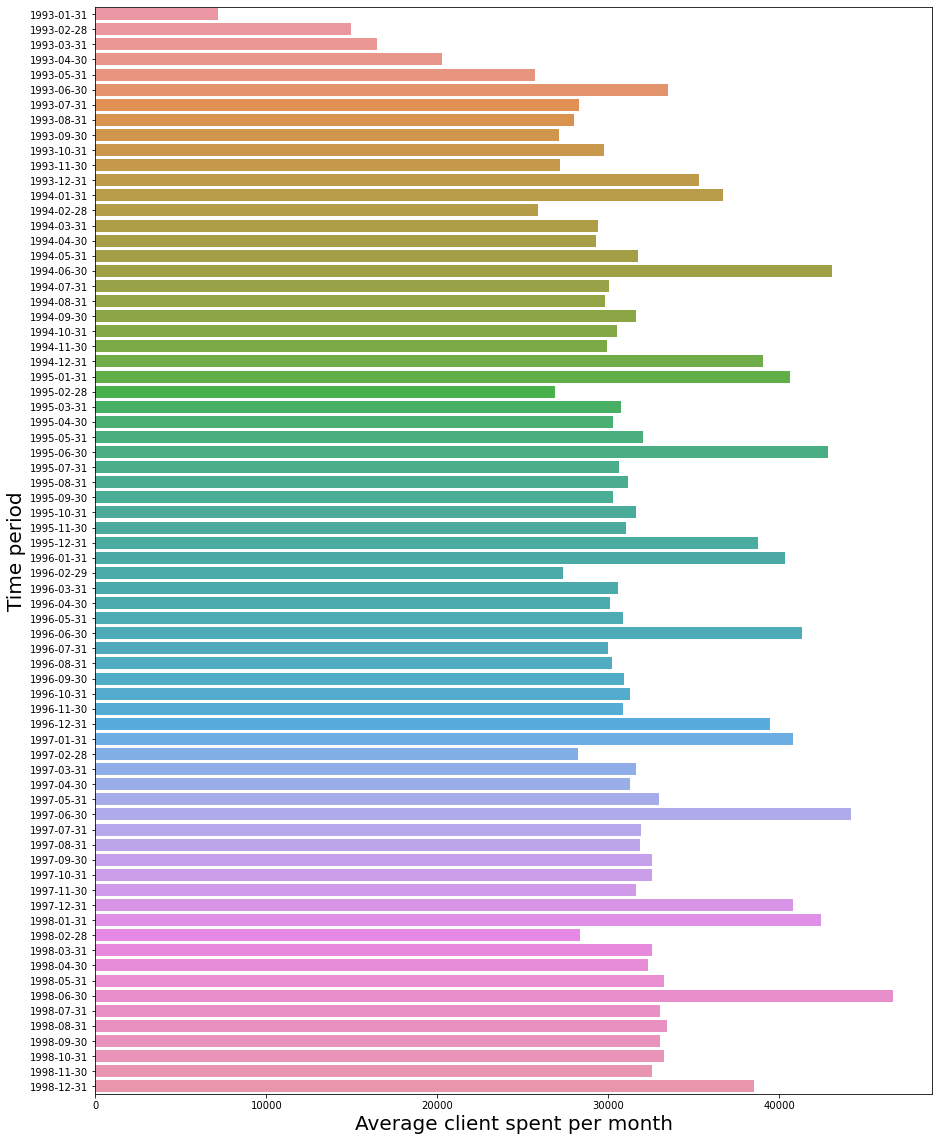

In [15]:
avg_customer_stat = avg_client_per_month(cust_trans_train)

#plotting the amount of money an average client spent over a month

plt.figure(figsize=(15,20))
sns.barplot(y=avg_customer_stat.DATE.dt.date, x=avg_customer_stat.AMOUNT_sum)
plt.xlabel("Average client spent per month", size=20)
plt.ylabel("Time period", size=20)


Text(0, 0.5, 'Time period')

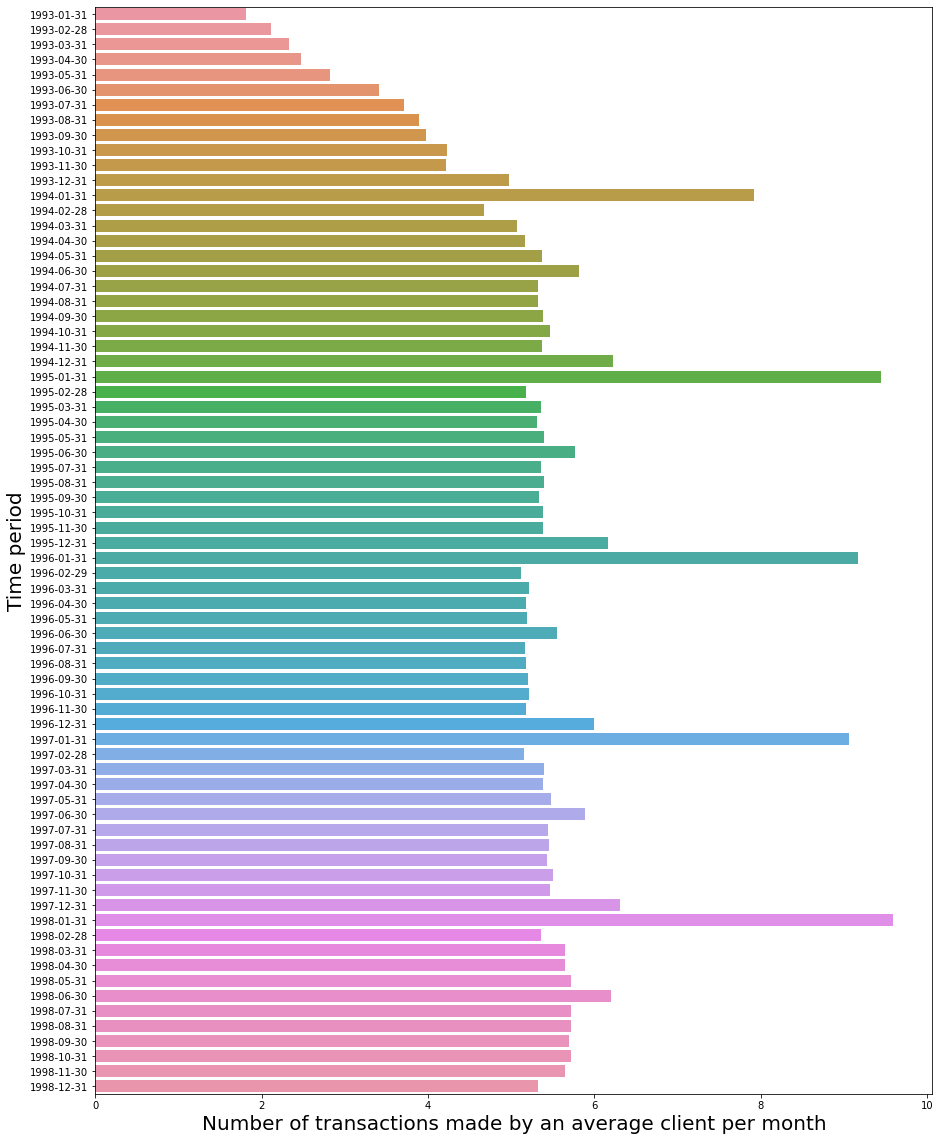

In [16]:
#plotting the amount of transactions an average client made over a month

plt.figure(figsize=(15,20))
sns.barplot(y=avg_customer_stat.DATE.dt.date, x=avg_customer_stat.TRANS_ID_count)
plt.xlabel("Number of transactions made by an average client per month", size=20)
plt.ylabel("Time period", size=20)

<ipython-input-14-214a3ef8c558>:4: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  avg_customer_stat.columns = ["_".join(x) for x in avg_customer_stat.columns.ravel()]


Text(0, 0.5, 'Time period')

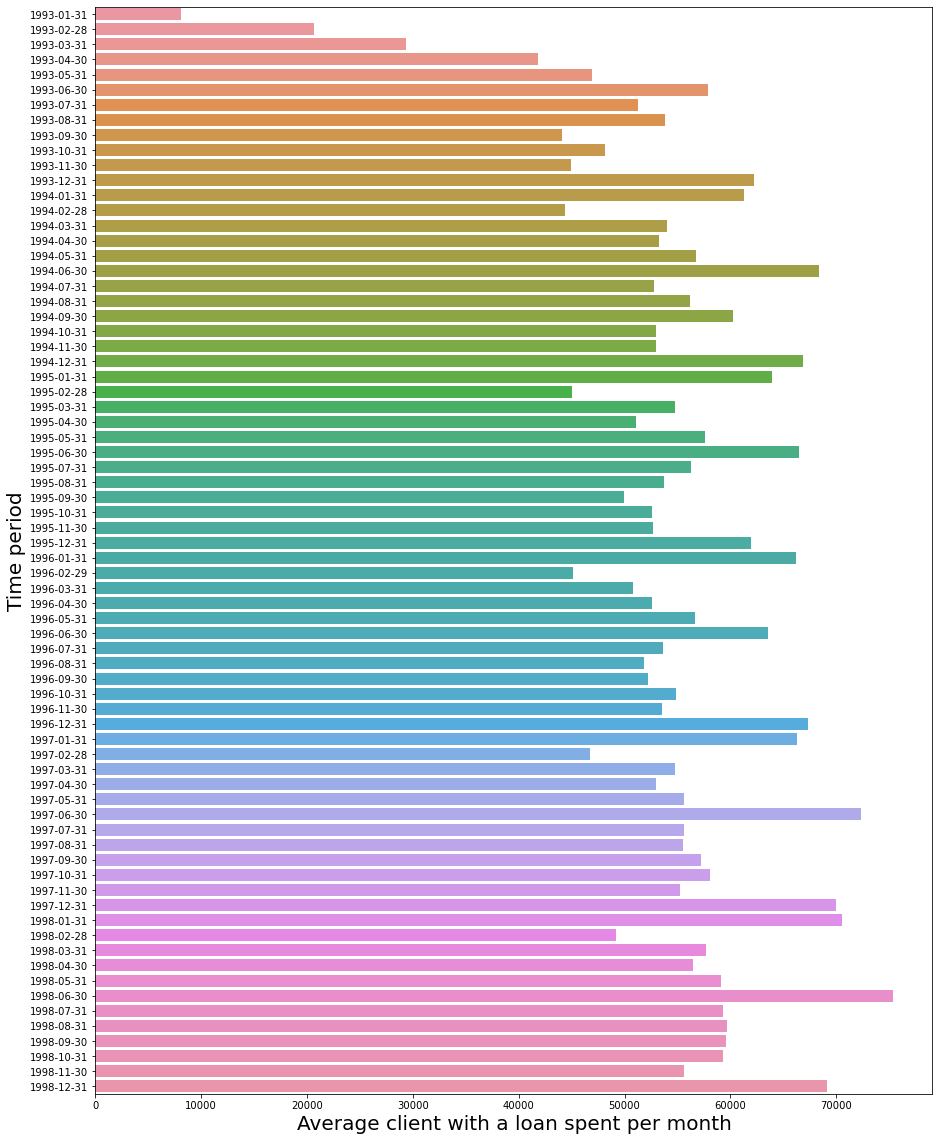

In [17]:
#it is interesting to see how the amount of money an average customer WITH A LOAN is different 
#(this is only important for the second part of the exercise)

cust_trans_train_loan = cust_trans_train.loc[cust_trans_train.LOAN == 1]
avg_customer_stat_loan = avg_client_per_month(cust_trans_train_loan)

plt.figure(figsize=(15,20))
sns.barplot(y=avg_customer_stat_loan.DATE.dt.date, x=avg_customer_stat_loan.AMOUNT_sum)
plt.xlabel("Average client with a loan spent per month", size=20)
plt.ylabel("Time period", size=20)

The monthly spending patterns of customers with a loan are consistent with the average, but these clients tend to spend significantly more money over month. Thus, average amount spent over month might be important for prediction. We will get back to this in the second part of the challenge.

Now we will look more closely at the client profiles and investigate how their spending patterns vary across different gender, age, and geographic groups.

In [18]:
period_length = '1M'

In [19]:
def monthly_stat_per_client(cust_trans, customers):
    trans_grouped_over_time_per_cust = cust_trans.groupby(['CLIENT_ID', pd.Grouper(key = 'DATE', freq=period_length)])
    cust_monthly_stat = trans_grouped_over_time_per_cust.agg(
    {'AMOUNT': [ 'sum'], 'TRANS_ID': 'count', 'BALANCE' : 'max'}).groupby('CLIENT_ID').mean()
    cust_monthly_stat.columns = ["_".join(x) for x in cust_monthly_stat.columns.ravel()]
    client_summary = pd.merge(left=customers, right=cust_monthly_stat, how='left', left_on='CLIENT_ID', right_on='CLIENT_ID')
    client_summary = client_summary.rename(
    columns = {'TRANS_ID_count' : 'AVG_NUM_TRANS_PER_MTH', 
               'AMOUNT_sum' : 'AVG_TOTAL_AMOUNT_PER_MONTH',
               'BALANCE_max' : 'AVG_MAX_BALANCE_PER_MONTH'})
    return client_summary


In [20]:
client_summary_train = monthly_stat_per_client(cust_trans_train, customer_df_train)
#client_summary_train.head()

<ipython-input-19-4382b31df57c>:5: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cust_monthly_stat.columns = ["_".join(x) for x in cust_monthly_stat.columns.ravel()]


In [21]:
client_summary_test = monthly_stat_per_client(cust_trans_test, customer_df_test)
#client_summary_test.head()

<ipython-input-19-4382b31df57c>:5: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cust_monthly_stat.columns = ["_".join(x) for x in cust_monthly_stat.columns.ravel()]


Investigating customer profile: here, we will look into aspects like gender, age group and geographic district to see whether these factors are related to spendings.

In [22]:
#monthly spendings per gender

print(client_summary_train.groupby('GENDER', as_index=False).AVG_NUM_TRANS_PER_MTH.mean())
print('-'*50)
print(client_summary_train.groupby('GENDER', as_index=False).AVG_TOTAL_AMOUNT_PER_MONTH.mean())

  GENDER  AVG_NUM_TRANS_PER_MTH
0      F               5.560763
1      M               5.569760
--------------------------------------------------
  GENDER  AVG_TOTAL_AMOUNT_PER_MONTH
0      F                32313.340895
1      M                34005.603895


Conclusion: men seem to spend slightly more per month, but not a lot. Let us now look at different age groups:

Text(0, 0.5, 'Average amount spent per month')

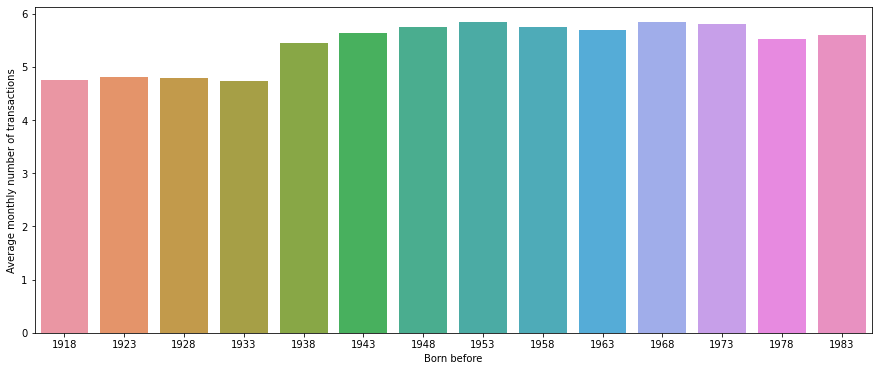

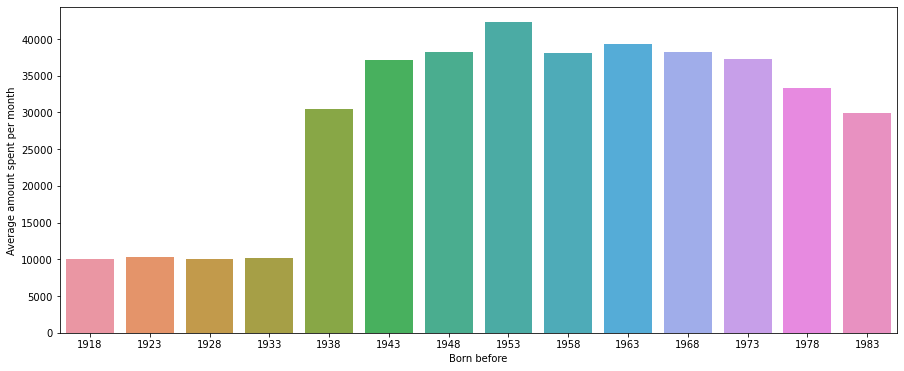

In [23]:
#monthly spendings per age group
clients_by_age = client_summary_train.groupby([pd.Grouper(key = 'BIRTH_DT', freq='5Y')])

avg_num_trans = clients_by_age.AVG_NUM_TRANS_PER_MTH.mean().to_frame().reset_index().rename(columns = {'BIRTH_DT' : 'BORN_BEFORE'})
plt.figure(figsize=(15,6))
sns.barplot(x=avg_num_trans.BORN_BEFORE.dt.year, y=avg_num_trans.AVG_NUM_TRANS_PER_MTH)
plt.xlabel("Born before")
plt.ylabel("Average monthly number of transactions")


avg_monthly_amount = clients_by_age.AVG_TOTAL_AMOUNT_PER_MONTH.mean().to_frame().reset_index().rename(columns = {'BIRTH_DT' : 'BORN_BEFORE'})
plt.figure(figsize=(15,6))
sns.barplot(x=avg_monthly_amount.BORN_BEFORE.dt.year, y=avg_monthly_amount.AVG_TOTAL_AMOUNT_PER_MONTH)
plt.xlabel("Born before")
plt.ylabel("Average amount spent per month")



Conclusion: we observe that average amounts spent per month vary quite significantly between age groups, while the average number of transactions is not that different. We notice that clients born before 1933 spent significantly less money, while the group that was born in 1948-1953 tends to spend more than other groups.

Now, we take a look at different geographic regions and see how average monthly spendings vary there.


Text(0, 0.5, 'Average amount spent over month')

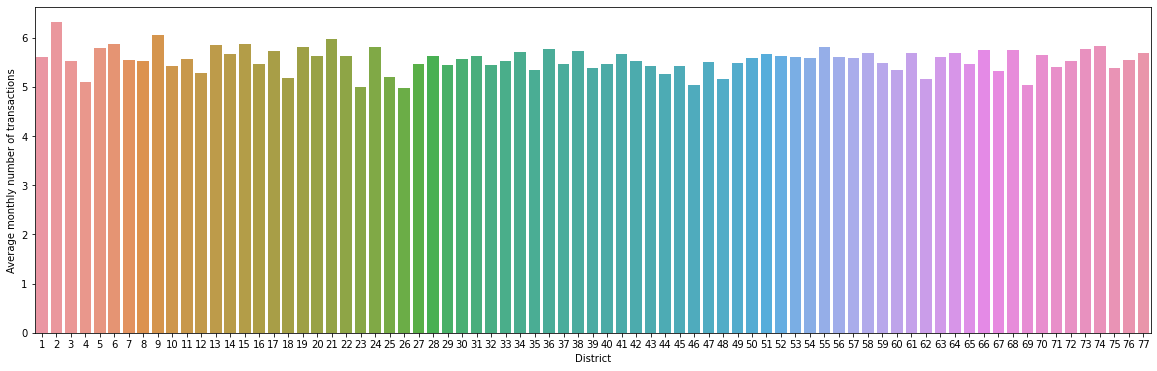

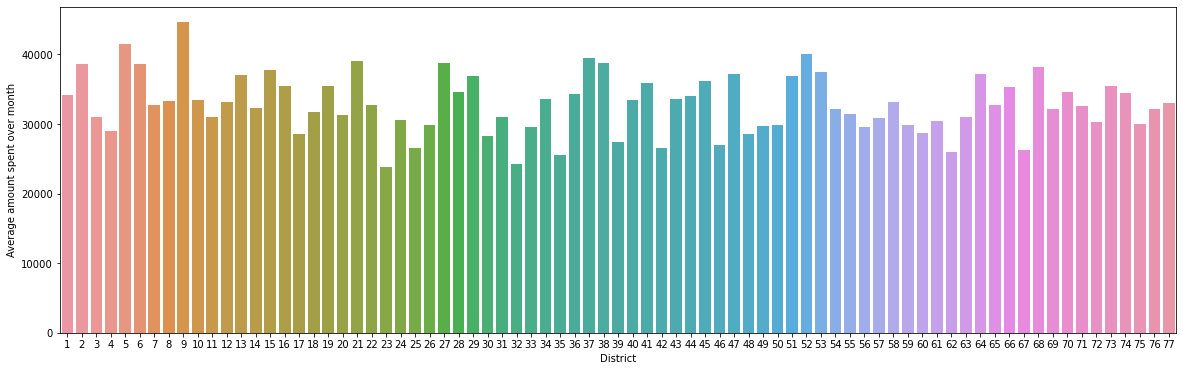

In [24]:
#average monthly transactions and amount spent per district

clients_by_district = client_summary_train.groupby(['DISTRICT_ID'])

avg_num_trans = clients_by_district.AVG_NUM_TRANS_PER_MTH.mean().to_frame().reset_index()
plt.figure(figsize=(20,6))
sns.barplot(x=avg_num_trans.DISTRICT_ID, y=avg_num_trans.AVG_NUM_TRANS_PER_MTH)
plt.xlabel("District")
plt.ylabel("Average monthly number of transactions")


avg_monthly_amount = clients_by_district.AVG_TOTAL_AMOUNT_PER_MONTH.mean().to_frame().reset_index()
plt.figure(figsize=(20,6))
sns.barplot(x=avg_monthly_amount.DISTRICT_ID, y=avg_monthly_amount.AVG_TOTAL_AMOUNT_PER_MONTH)
plt.xlabel("District")
plt.ylabel("Average amount spent over month")


#clients_by_district.AVG_TOTAL_AMOUNT_PER_MONTH.mean().to_frame().reset_index()

Conclusion: while the number of transactions made per month seems homogenous, the amount of money spent per months varies quite significantly between districts.

Let us now see how the average salary varies across geographical regions; my naive intuition is that it should correlate to the average amounts of spendings.

mean salary across districts 9031
standard deviation 790


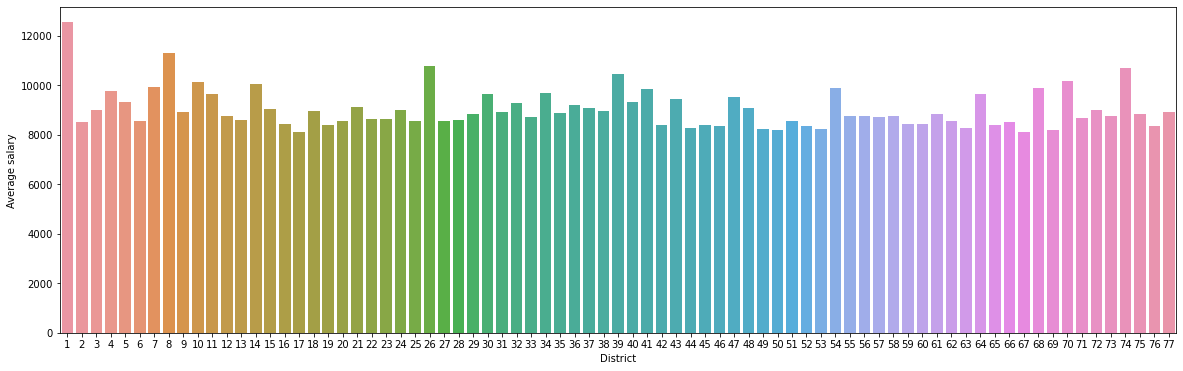

In [25]:
plt.figure(figsize=(20,6))
sns.barplot(x=district_df.DISTRICT_ID, y=district_df.AVG_SALARY)
plt.xlabel("District")
plt.ylabel("Average salary")

print("mean salary across districts %d" % district_df.AVG_SALARY.mean())
print ("standard deviation %d"  % district_df.AVG_SALARY.std())

Contrary to my intuition, the average salary does not vary that much over the districts; what is even more interesting is that the average salary seems to be much less than the average amount spent per month for many clients. Let us take a closer look at the monthly spendings.

Text(0, 0.5, 'Average amount spent per month')

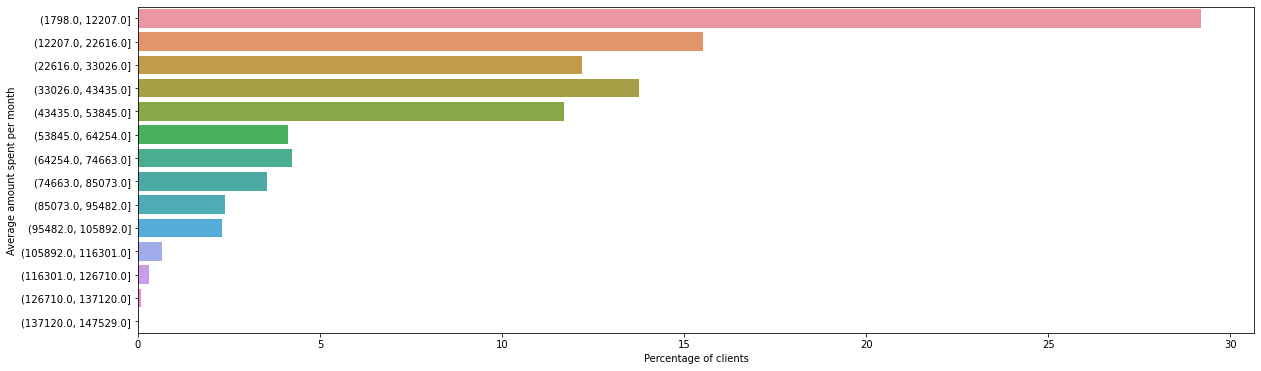

In [26]:
amount_levels = np.around(np.linspace(start=client_summary_train['AVG_TOTAL_AMOUNT_PER_MONTH'].min()-1, stop=client_summary_train['AVG_TOTAL_AMOUNT_PER_MONTH'].max()+1, num=15))
amount_bins = pd.cut(client_summary_train['AVG_TOTAL_AMOUNT_PER_MONTH'], amount_levels)#.reset_index()

plt.figure(figsize=(20,6))
sns.barplot(y=amount_bins.value_counts(sort=False).index, x=amount_bins.value_counts(sort=False)/len(amount_bins)*100)
plt.xlabel("Percentage of clients")
plt.ylabel("Average amount spent per month")


This is a very interesting plot. While the majority of clients exhibit the behaviour I could expect, some spend more than 5 * average salary. It would be interesting to investigate this further by considering different groups of customers: for instance, those who spend more than 50 000 per months on average and others. However, I am not sure how to select the exact threshold in a rigorous way.

# Feature creation and selection

We now focus on the second part: predicting which customers were granted a loan. We will use some of the features that we already created (average spendings per month, average number of transactions made per month), and create others. We start by analyzing how different characteristics of the client profile affect the existence of a loan. We consider 4 features to start with: gender, district, average amount of money spent per month, and birth year. These features reflect different aspects of the customer profile, and our current hypothesis (in the absence of domain knowledge) is that they might correlate with the target feature. 

In [27]:
#train and test split
X_train = client_summary_train.set_index('CLIENT_ID')
X_test = client_summary_test.set_index('CLIENT_ID')
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=1)



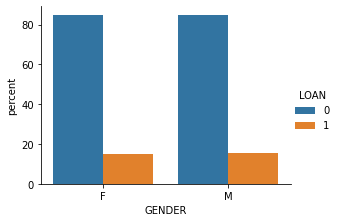

In [28]:
#let us see if the gender of a client is somehow related to the fact that he/she has a loan:

X_train.groupby('GENDER')['LOAN'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='GENDER',y='percent',hue='LOAN',kind='bar',height=3, aspect=4/3)

There does not seem to be a significant relationship between the gender and the loan; we can decide later whether this feature should be included.

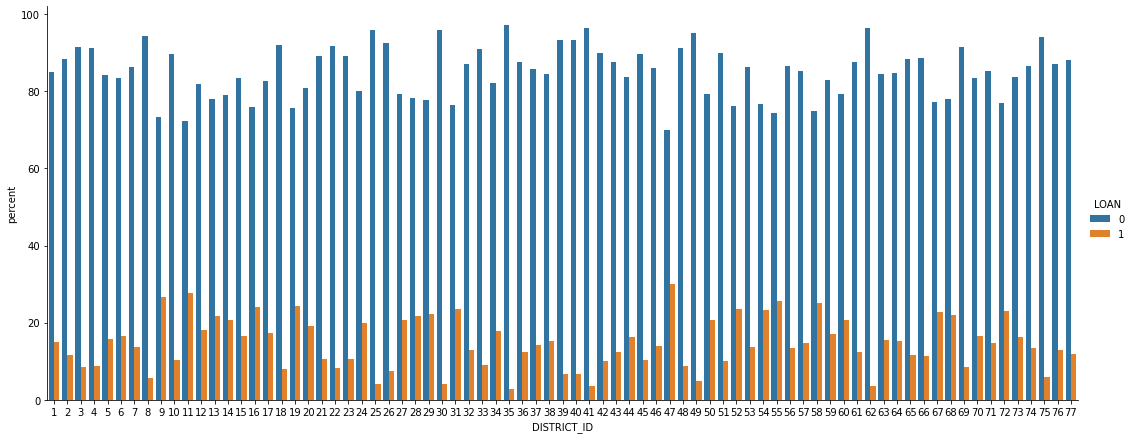

In [29]:
#now we see how the district might be related to the loan:

X_train.groupby('DISTRICT_ID')['LOAN'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='DISTRICT_ID',y='percent',hue='LOAN',kind='bar',height=6, aspect=15/6)

From this plot we can see that the ratio of clients with a loan somewhat varies between different districts, and thus it might make sense to include this as a feature. Perhaps adding the average salary per district might also help, as it can provide some indication of the client's income.

number of clients per spending group:


(1813.0, 12221.0]       839
(12221.0, 22629.0]      445
(33038.0, 43446.0]      399
(22629.0, 33038.0]      359
(43446.0, 53854.0]      331
(64262.0, 74671.0]      122
(53854.0, 64262.0]      118
(74671.0, 85079.0]       99
(85079.0, 95487.0]       72
(95487.0, 105896.0]      69
(105896.0, 116304.0]     17
(116304.0, 126712.0]      7
(126712.0, 137121.0]      2
(137121.0, 147529.0]      1
Name: AVG_TOTAL_AMOUNT_PER_MONTH, dtype: int64

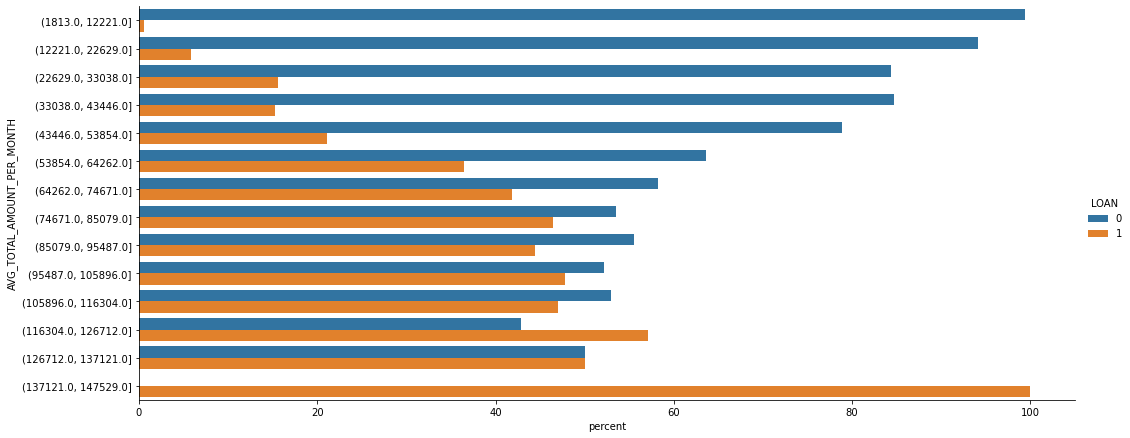

In [30]:
#let's see how the amount spent per month is related to the loan information

amount_levels = np.around(np.linspace(start=X_train['AVG_TOTAL_AMOUNT_PER_MONTH'].min()-1, stop=X_train['AVG_TOTAL_AMOUNT_PER_MONTH'].max()+1, num=15))
amount_bins = pd.cut(X_train['AVG_TOTAL_AMOUNT_PER_MONTH'], amount_levels)
X_train.groupby(amount_bins)['LOAN'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), y='AVG_TOTAL_AMOUNT_PER_MONTH',x='percent',hue='LOAN',kind='bar',height=6, aspect=15/6)
print("number of clients per spending group:")
amount_bins.value_counts()


It seems that the average amount spent over month can be a good feature for our prediction: the ratio of clients with a loan varies quite notably between different groups. At the same time, the groups are highly imbalanced: there are significantly more clients in groups that spend less, as we have seen before. Thus, my intuition is that this feature can be especially helpful to predict the loan for those clients that belong to the high-spending groups.

Perhaps it also makes sense to add other features reflecting the economy of the clients, such as the average balance on the account, the prevalent type of transactions, the average amount of transactions.

(1946.0, 1954.0]    430
(1968.0, 1976.0]    423
(1939.0, 1946.0]    379
(1961.0, 1968.0]    376
(1954.0, 1961.0]    371
(1976.0, 1983.0]    278
(1932.0, 1939.0]    251
(1924.0, 1932.0]    197
(1917.0, 1924.0]    175
Name: BIRTH_YEAR, dtype: int64

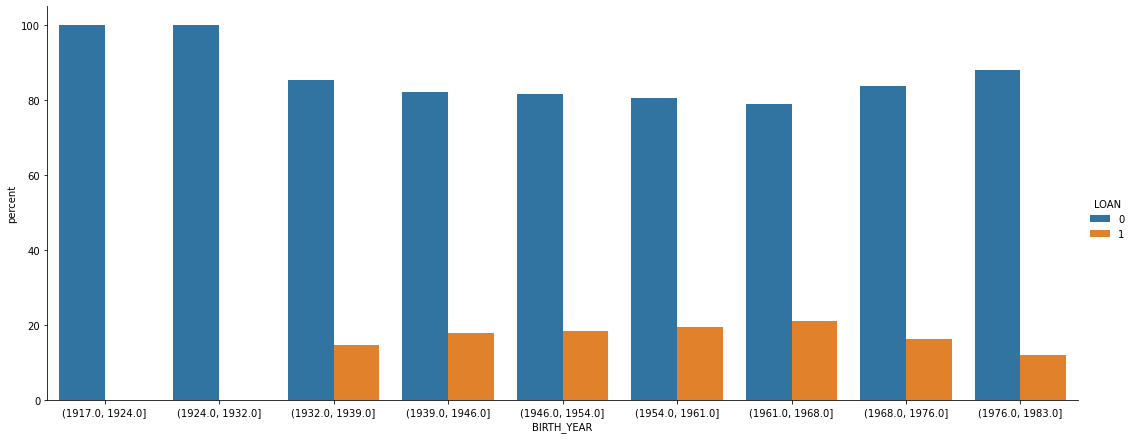

In [31]:
#Instead of the birth date, we will consider the year only:
X_train['BIRTH_YEAR'] = X_train.BIRTH_DT.dt.year
X_val['BIRTH_YEAR'] = X_val.BIRTH_DT.dt.year
X_test['BIRTH_YEAR'] = X_test.BIRTH_DT.dt.year

#And look how it is related to the loan:
age_levels = np.around(np.linspace(start=X_train['BIRTH_YEAR'].min()-1, stop=X_train['BIRTH_YEAR'].max()+1, num=10))
age_bins = pd.cut(X_train['BIRTH_YEAR'], age_levels)
X_train.groupby(age_bins)['LOAN'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='BIRTH_YEAR',y='percent',hue='LOAN',kind='bar',height=6, aspect=15/6)


age_bins.value_counts()

We notice some relationship between the age of a client and whether he or she has a loan; importantly, clients who were born before 1932 don't seem to have a loan. In terms of the number of clients, there is some variability, but all groups seem to be sufficiently represented. The birth year might be helpful for prediction.

Let us now add extra features. Because I have no domain knowledge (apart from some naive intuition), I want to first look at many features reflecting different aspects and see how they correlate with the target and with each other. 
For this, we look at the transaction and district dataframes, and select what seems intuitively might make sense. From the district dataframe, we take the average salary of the district. From the transactions, we will take the information about amounts of money spent per client overall (sum of all transactions and the largest transaction), the information about account balance (min, average and max), the dates of the first and the last transaction (we will later transform this into the total number of time of being an active client), and, finally, the most common operation performed by a client and the most common transaction type (the operation field is more informative but less reliable, as many values are missing there).

In [32]:
#adding location features
location_features = district_df[['DISTRICT_ID', 'AVG_SALARY']]


transactions_by_acc = transaction_df[['ACCOUNT_ID', 'BALANCE', 'AMOUNT', 'DATE', 'OPERATION', 'TYPE']].groupby('ACCOUNT_ID')
transaction_features = transactions_by_acc.agg(
    {'AMOUNT': ['sum', 'max'], 'DATE': ['min', 'max'], 'BALANCE' : ['min', 'mean', 'max'], 
     'OPERATION' : lambda x:x.value_counts().index[0], 'TYPE' :  lambda x:x.value_counts().index[0]})

#adding spending features
transaction_features.columns = ["_".join(x) for x in transaction_features.columns.ravel()]
transaction_features = transaction_features.rename(columns= {'OPERATION_<lambda>' : 'OPERATION_mode', 'TYPE_<lambda>' : 'TYPE_mode'})

#add financial and location features
X_train = pd.merge(left=X_train, right=location_features, how='left', left_on='DISTRICT_ID', right_on='DISTRICT_ID')
X_val = pd.merge(left=X_val, right=location_features, how='left', left_on='DISTRICT_ID', right_on='DISTRICT_ID')
X_test = pd.merge(left=X_test, right=location_features, how='left', left_on='DISTRICT_ID', right_on='DISTRICT_ID')

X_train = pd.merge(left=X_train, right=transaction_features, how='left', left_on='ACCOUNT_ID', right_on='ACCOUNT_ID')
X_val = pd.merge(left=X_val, right=transaction_features, how='left', left_on='ACCOUNT_ID', right_on='ACCOUNT_ID')
X_test = pd.merge(left=X_test, right=transaction_features, how='left', left_on='ACCOUNT_ID', right_on='ACCOUNT_ID')



<ipython-input-32-7d2e35b6ba4a>:11: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  transaction_features.columns = ["_".join(x) for x in transaction_features.columns.ravel()]


Now let us take care of the non-numeric variables. We will count the total number of days between the first and the last transaction and drop the first and last transaction dates; this might be a very naive idea, but my intuition is that those who spent more time as a client are more likely to be granted a loan.
Furthermore, we will use LabelEncoder.

In [33]:
#remove non-numeric variables; for this, fit target encoder on train data
cat_features = ['GENDER', 'OPERATION_mode', 'TYPE_mode']

le = preprocessing.LabelEncoder()
for col in cat_features:
    X_train[col+'_enc'] = le.fit_transform(X_train[col])
    X_val[col+'_enc'] = le.transform(X_val[col])
    X_test[col+'_enc'] = le.transform(X_test[col])


In [34]:
#instead of looking at the dates of the first and the last transaction, we will create another feature: 
#how long the customer has been using the account to make transactions.

X_train['TOTAL_TIME'] = (X_train.DATE_max - X_train.DATE_min)/np.timedelta64(1, 'D')
X_val['TOTAL_TIME'] = (X_val.DATE_max - X_val.DATE_min)/np.timedelta64(1, 'D')
X_test['TOTAL_TIME'] = (X_test.DATE_max - X_test.DATE_min)/np.timedelta64(1, 'D')

#we drop the non-numeric features now
non_numeric_feat = ['GENDER', 'BIRTH_DT', 'DATE_min', 'DATE_max', 'OPERATION_mode', 'TYPE_mode']
X_train = X_train.drop(non_numeric_feat, axis=1)
X_val = X_val.drop(non_numeric_feat, axis=1)
X_test = X_test.drop(non_numeric_feat, axis=1)



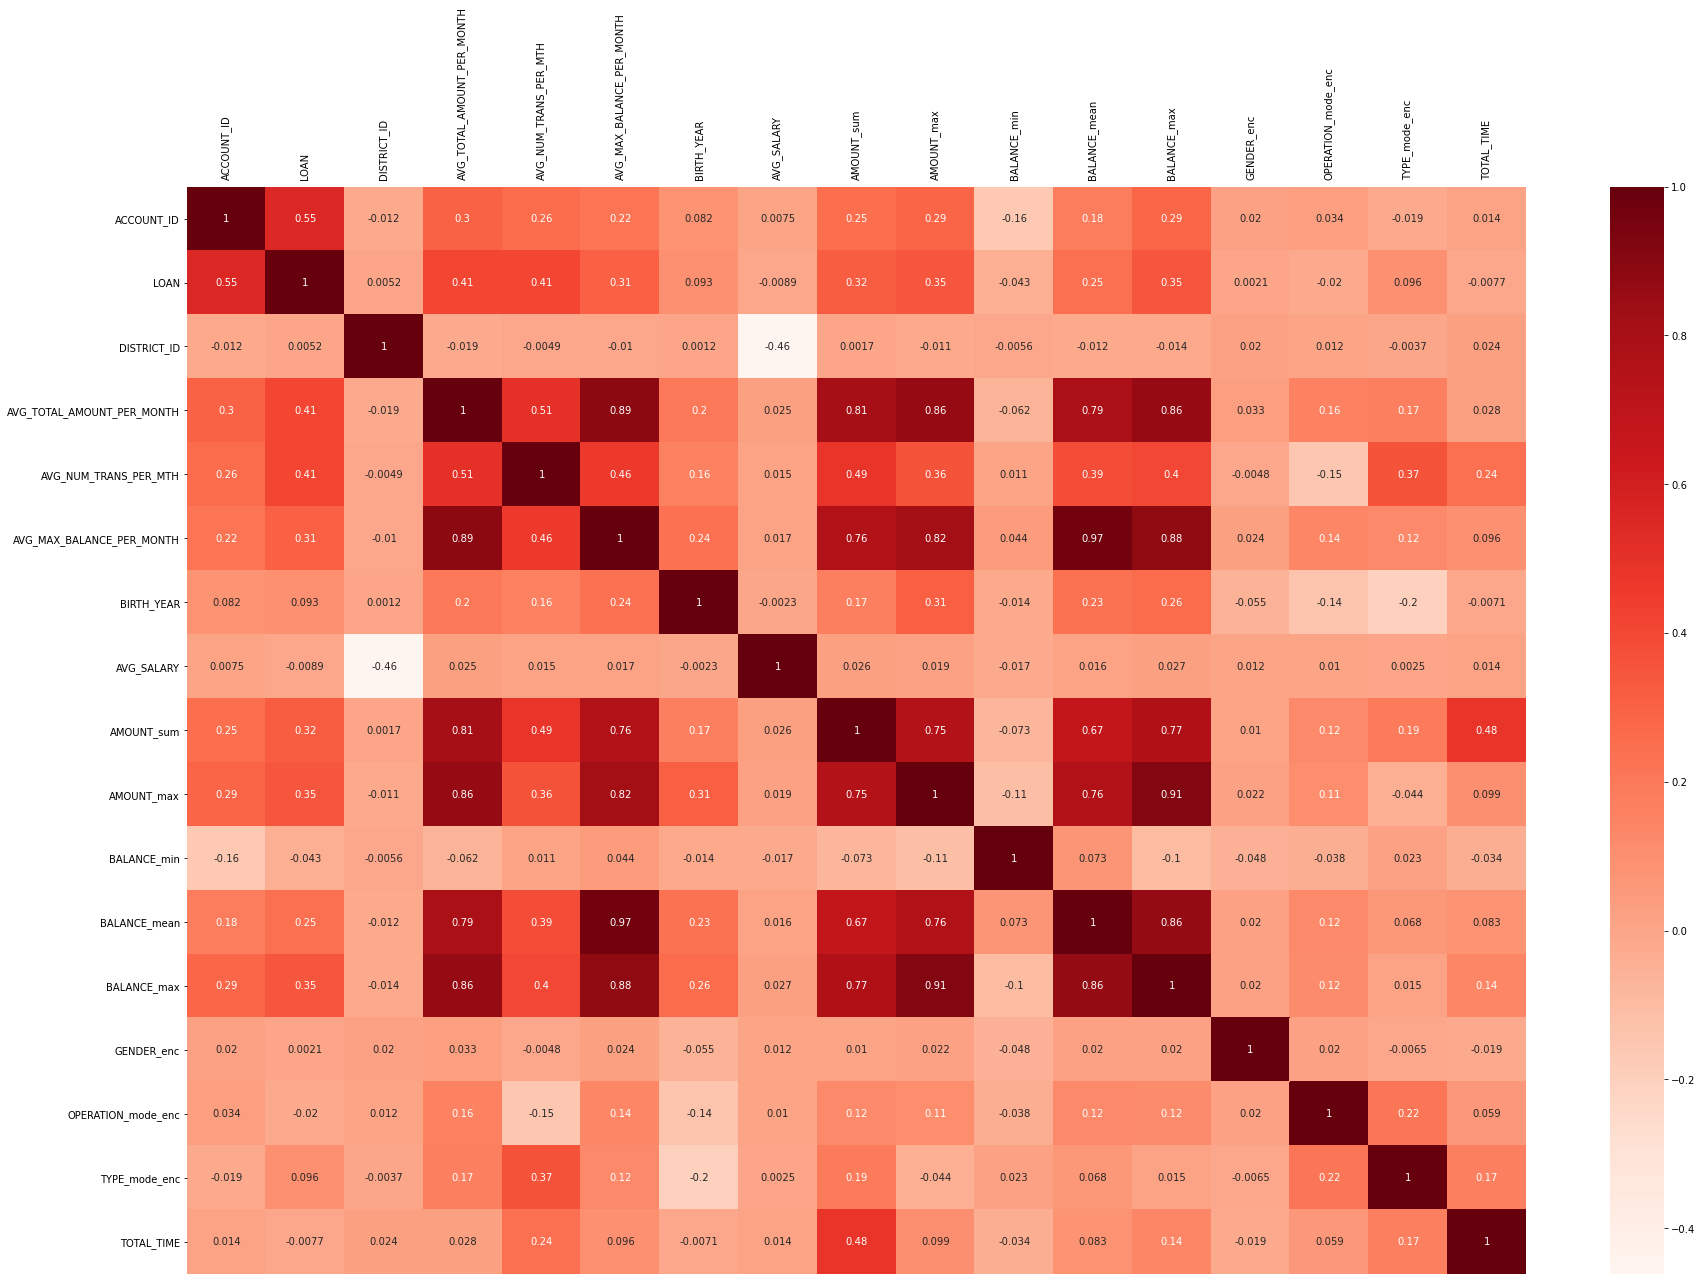

In [35]:
#check correlation between columns
plt.figure(figsize=(30,20))
cor = X_train.corr()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



Some features have high correlation between each other; I tried to naively eilminate some of them. In the future, it would be interesting to see what is the minimum set of features needed for a good prediction. For this, a procedure where we gradually add (or eliminate) features, train the model, and perform cross validation would be an option.

I also drop the gender feature as it does not seem to correlate with the target.

In [36]:
#drop redundant features based on correlation values
drop_redundant = True
#features with low correlation with the LOAN:
drop_low_corr = True

redundant_feat = ['AMOUNT_max', 'BALANCE_max', 'AMOUNT_sum',  'DISTRICT_ID',   'AVG_MAX_BALANCE_PER_MONTH']
low_correlation_feat = ['GENDER_enc']

if drop_redundant:
    X_train = X_train.drop(redundant_feat, axis=1)
    X_val = X_val.drop(redundant_feat, axis=1)
    X_test = X_test.drop(redundant_feat, axis=1)

if drop_low_corr:
    X_train = X_train.drop(low_correlation_feat, axis=1)
    X_val = X_val.drop(low_correlation_feat, axis=1)
    X_test = X_test.drop(low_correlation_feat, axis=1)

#looking at correlations once again just for convenience
#plt.figure(figsize=(30,20))
#cor = X_train.corr()
#plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()

(0.0, 393.0]          232
(393.0, 785.0]        226
(785.0, 1178.0]       248
(1178.0, 1570.0]      224
(1570.0, 1963.0]      245
(1963.0, 2355.0]      242
(2355.0, 2748.0]      238
(2748.0, 3140.0]      237
(3140.0, 3533.0]      238
(3533.0, 3925.0]      255
(3925.0, 4318.0]       96
(4318.0, 4710.0]       52
(4710.0, 5103.0]       27
(5103.0, 5495.0]       29
(5495.0, 5888.0]       19
(5888.0, 6280.0]       16
(6280.0, 6673.0]       19
(6673.0, 7065.0]       17
(7065.0, 7458.0]       18
(7458.0, 7850.0]       18
(7850.0, 8243.0]       23
(8243.0, 8635.0]       15
(8635.0, 9028.0]       14
(9028.0, 9420.0]       23
(9420.0, 9813.0]       24
(9813.0, 10205.0]      18
(10205.0, 10598.0]     21
(10598.0, 10990.0]     26
(10990.0, 11383.0]     20
Name: ACCOUNT_ID, dtype: int64

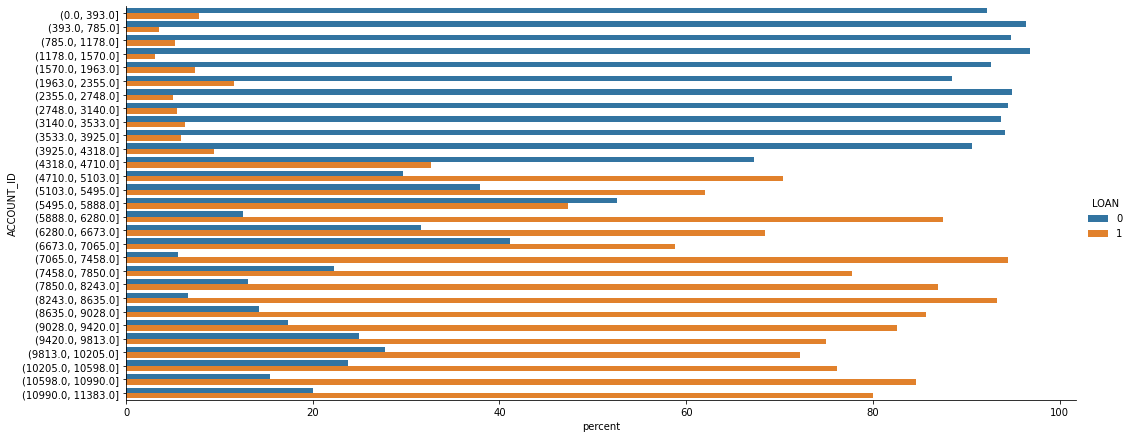

In [37]:
#investigate the surprisingly high correlation between ACCOUNT_ID and LOAN

account_id_levels = np.around(np.linspace(start=X_train['ACCOUNT_ID'].min()-1, stop=X_train['ACCOUNT_ID'].max()+1, num=30))
account_bins = pd.cut(X_train['ACCOUNT_ID'], account_id_levels)
X_train.groupby(account_bins)['LOAN'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), y='ACCOUNT_ID',x='percent',hue='LOAN',kind='bar',height=6, aspect=15/6)
account_bins.value_counts(sort=False)

This plot is very interesting. It looks like there are 2 groups of clients: those with low Account ID (this group is much more numerous, and clents here have a low loan rate), and those with higher Account IDs, who seem to get loans much more often. We remember now that we have another suspicious feature - the average amount spent per month. Let us look if there is any connection between these two features and the loan.

<AxesSubplot:xlabel='ACCOUNT_ID', ylabel='AVG_TOTAL_AMOUNT_PER_MONTH'>

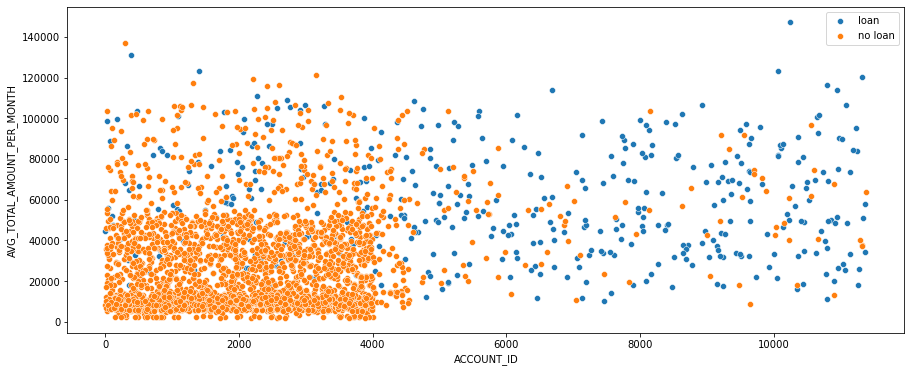

In [38]:
#what about ACCOUNT_ID vs average monthly spendings?
X_loan = X_train.loc[X_train['LOAN'] == 1]
X_noloan = X_train.loc[X_train['LOAN'] == 0]

plt.figure(figsize=(15,6))
sns.scatterplot(x=X_loan['ACCOUNT_ID'], y=X_loan['AVG_TOTAL_AMOUNT_PER_MONTH'], label='loan')
sns.scatterplot(x=X_noloan['ACCOUNT_ID'], y=X_noloan['AVG_TOTAL_AMOUNT_PER_MONTH'], label='no loan')

Thoughts: it seems like the majority of customers tend to spend less than 60 000 per month, do not have a loan, and for some reason happen to have low account ID numbers. 

Perhaps account ID somehow indicates the status or category of a client? For example, maybe the small account numbers often correspond to "regular" salary/pension accounts?

Since we cannot be certain that the account ID is a meanignful feature, but the data suggests that it is likely to have a meaning, we will consider two cases: when we assume that it is a meaningful number and include it as a feature into the model, and when it is considered unreliable and is therefore omitted.


In [39]:
#adding a flag indicating whether Account ID is considered a reliable predictor
no_acc_id = False
if no_acc_id:
    X_train = X_train.drop(['ACCOUNT_ID'], axis=1)
    X_val = X_val.drop(['ACCOUNT_ID'], axis=1)
    X_test = X_test.drop(['ACCOUNT_ID'], axis=1)

Remark: I started with a quite large set of features; Ideally, I should have probably started with a smaller set, interatively add features and see if they improve the prediction.

# Prediction

In [40]:
#remove the target column
Y_train = X_train['LOAN']
X_train = X_train.drop('LOAN', axis=1)
Y_val = X_val['LOAN']
X_val = X_val.drop('LOAN', axis=1)
Y_test = X_test['LOAN']
X_test = X_test.drop('LOAN', axis=1)

In [41]:
#checking balance in training

print("the ratio of positive examples: ", Y_train.sum()/len(Y_train))

the ratio of positive examples:  0.1517361111111111


Conclusion: the dataset is imbalanced: only 15% of clients have a loan; this means that using accuracy score to evaluate the model would not make much sense, since we can get high accuracy just by always predicting LOAN=0.

Instead we will use area under precision and recall curve (AP).

We will train an XGBoost classifier. My understanding is that the focus of the assignment is not on the model accuracy, so I did not spend much time tuning parameters and testing different models. Ideally, I should have performed grid search for the main parameters such as the number of estimators, max depth, and learning rate. I only tuned the number of estimators and the max depth using the validation set.

In [42]:
weights = (Y_test == 0).sum() / (1.0 * (Y_test == 1).sum())

In [43]:
#(commented out, used for tuning the number of estimators)

#n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 20)]
#for n_est in n_estimators:
#    model = XGBClassifier(n_estimators=n_est, max_depth = 3, scale_pos_weight = weights, verbosity = 0, use_label_encoder=False)
#    model.fit(X_train, Y_train, verbose=False)
#    print ('n_est %d' %n_est)
#    probabilities_val = model.predict_proba(X_val)
#    print('validation set AP = {}'.format(average_precision_score(Y_val, \
#                                              probabilities_val[:, 1])))

In [44]:
#we pick n_estimators  based on the search above; now let us fit the model on the whole dataset 

if no_acc_id:
    n_est = 50
else:
    n_est = 30

model = XGBClassifier(n_estimators=n_est, max_depth = 3, scale_pos_weight = weights, verbosity = 0, use_label_encoder=False)
model = model.fit(X_train, Y_train)
probabilities_train = model.predict_proba(X_train)
print('training set AP = {}'.format(average_precision_score(Y_train, \
                                              probabilities_train[:, 1])))
probabilities_val = model.predict_proba(X_val)
print('validation set AP = {}'.format(average_precision_score(Y_val, \
                                              probabilities_val[:, 1])))


training set AP = 0.9348227264536798
validation set AP = 0.8460587086053925


In [45]:
model.fit(X_train.append(X_val), Y_train.append(Y_val), verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.610294117647059,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

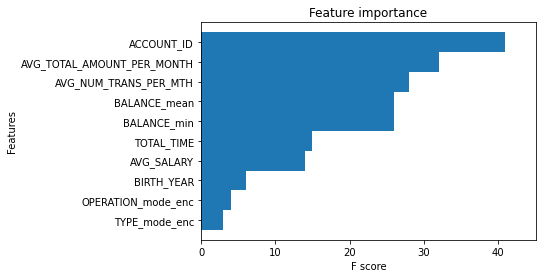

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_importance(model, height = 1, grid = False, \
                     show_values = False,  ax = ax);


Let us now look at how discriminative the 2 most important features are. For this, we visualize the predictions on the validation set and look at how the positive (loan) and negative (no loan) examples from the ground truth and our prediction are distributed with respect to them.

In [47]:
y_pred_val = np.around(probabilities_val[:, 1])#model.predict(X_val)
X_pred = X_val.copy()
X_pred['LOAN'] = pd.Series(y_pred_val).values
X_val['LOAN'] = Y_val
important_feature_a = 'AVG_TOTAL_AMOUNT_PER_MONTH'
if no_acc_id:
    important_feature_b = 'AVG_NUM_TRANS_PER_MTH'
else:
    important_feature_b = 'ACCOUNT_ID'

<AxesSubplot:xlabel='ACCOUNT_ID', ylabel='AVG_TOTAL_AMOUNT_PER_MONTH'>

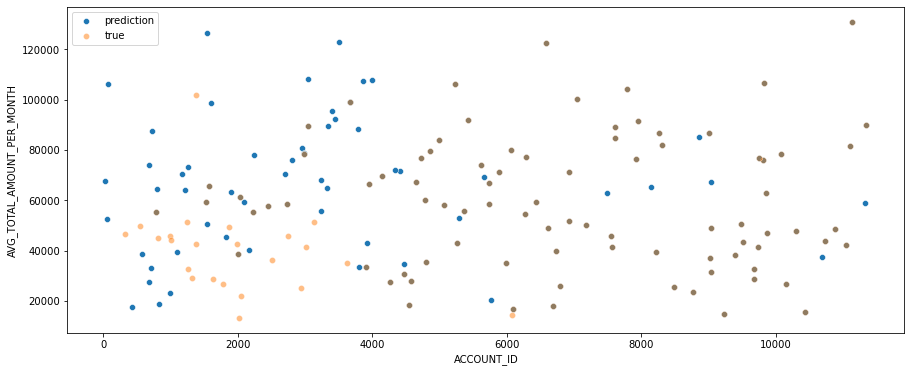

In [48]:
X_val_pos = X_val.loc[X_val.LOAN==1]
X_pred_pos = X_pred.loc[X_pred.LOAN==1]

plt.figure(figsize=(15,6))
sns.scatterplot(x=X_pred_pos[important_feature_b], y=X_pred_pos[important_feature_a], label='prediction', alpha=1)
sns.scatterplot(x=X_val_pos[important_feature_b], y=X_val_pos[important_feature_a], label='true', alpha=0.5)

This plot allows us to see which samples are missclassified, and how they are related to the 2 most important features we considered.
We observe that in both cases (when considering Account ID and when not) we fail to correctly classify a group of clients with a loan
that cannot be differentiated using these features (e.g.,  low avg number of transactions/low spendings, and low account ID/low spendings, respectively).

To improve the model, we would need to further investigate how to distinguish these clients from the others, and which features would help here.

The next plot complements it by visualizing the negative class.

<AxesSubplot:xlabel='ACCOUNT_ID', ylabel='AVG_TOTAL_AMOUNT_PER_MONTH'>

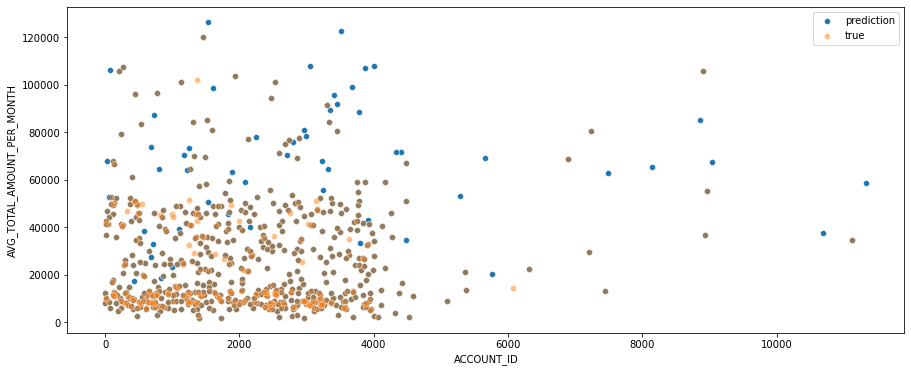

In [49]:
X_val_neg = X_val.loc[X_val.LOAN==0]
X_pred_neg = X_pred.loc[X_pred.LOAN==0]

plt.figure(figsize=(15,6))
sns.scatterplot(x=X_val_neg[important_feature_b], y=X_val_neg[important_feature_a], label='prediction', alpha=1)
sns.scatterplot(x=X_pred_neg[important_feature_b], y=X_pred_neg[important_feature_a], label='true', alpha=0.5)

## Evaluation

Now we evaluate the trained model on the test dataset. We notice that there is a very high differentce in accuracy depending on whether we assume that the Account ID is a reliable feature or not. Without it, the accuracy is not so high, although, since we only have around 15% positive samples, the result is significantly better than a random baseline (which would have score around 0.15 in terms of the area under precision and recall curve).

In [50]:
#evaluating on the test set
probabilities_test = model.predict_proba(X_test)
print('test set AP = {}'.format(average_precision_score(Y_test, \
                                              probabilities_test[:, 1])))

test set AP = 0.819973991895529


Let us now look at the confusion matrix:

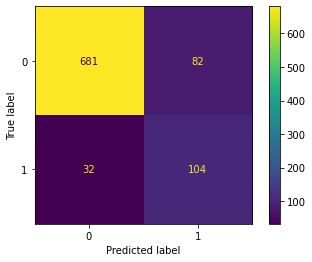

In [51]:
plot_confusion_matrix(model, X_test, Y_test)